In [76]:
import shutil
from pathlib import Path
import os
import zipfile
import gdown

import numpy as np
import math
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch import optim
from torchvision import utils

In [ ]:
def extract_gdrive_file(folder_id, output_path):
    '''
    Download and extract a ZIP file from Google Drive.
    Parameters:
    - folder_id (str): The unique ID of the file from G Drive link.
    - output_path (str): The path where the files will be extracted.
    '''
    # check whether the data already exists
    if os.path.exists(output_path) and len(os.listdir(output_path)) > 0:
        print("Data already exists. I'm skipping the downloading and unpacking.")
        return

    # create file for extracted files, if not existed
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # download file from Google Drive
    zip_url = f"https://drive.google.com/uc?export=download&id={folder_id}"
    zip_filename = os.path.join(output_path, "brain_tumors_img.zip")
    print(f"Downloading file from Google Drive to {zip_filename}...")
    gdown.download(zip_url, zip_filename, quiet=False)

    # extract the file to output path
    print(f"Unzipping file: {zip_filename}...")
    try:
        with zipfile.ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(output_path)
        print("Unzipping of the file is complete!")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP archive.")
        return

    # delete zip file after extraction
    os.remove(zip_filename)
    print("ZIP file has been removed!")

    # Remove the _MACOSX folder if exists
    macosx_path = os.path.join(output_path, '__MACOSX')
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print("_MACOSX folder has been removed!")

    # Remove .DS_Store files from the extracted folders
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed file: {file_path}")



FOLDER_ID = "1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB"
OUTPUT_PATH = "./data/tumors"
extract_gdrive_file(FOLDER_ID, OUTPUT_PATH)

In [53]:
# directories for images
TRAIN_DIR = Path('data/tumors/brain_tumors_img/Training')
TEST_DIR = Path('data/tumors/brain_tumors_img/Testing')
TRAIN_GAN_DIR = Path('data/tumors/brain_tumors_img/TrainingGAN')

os.makedirs(TRAIN_GAN_DIR, exist_ok=True)

def copy_contents(src1,src2, dst):
    if not os.path.exists(dst):
        os.makedirs(dst)
        print(f'Folder {dst} has been created.')
    else:
        print(f'Folder {dst} already exists.')
    
    def copy_images(src):
        for image in os.listdir(src):
            s = os.path.join(src, image)
            d = os.path.join(dst, image)
            if os.path.isdir(s):
                shutil.copytree(s, d, dirs_exist_ok=True)
                print(f"Copied folder: {s} -> {d}")
            else:
                shutil.copy2(s, d)
                print(f"Copied images: {s} -> {d}")
            
    # Merge images from training dataset and testing dataset folders            
    copy_images(src1)
    copy_images(src2)
    print(f"Images from: {src1} and {src2} are merged and saved in {dst}")
    
copy_contents(TRAIN_DIR, TEST_DIR, TRAIN_GAN_DIR)

Folder data/tumors/brain_tumors_img/TrainingGAN already exists.
Copied folder: data/tumors/brain_tumors_img/Training/pituitary -> data/tumors/brain_tumors_img/TrainingGAN/pituitary
Copied folder: data/tumors/brain_tumors_img/Training/notumor -> data/tumors/brain_tumors_img/TrainingGAN/notumor
Copied folder: data/tumors/brain_tumors_img/Training/glioma -> data/tumors/brain_tumors_img/TrainingGAN/glioma
Copied folder: data/tumors/brain_tumors_img/Training/meningioma -> data/tumors/brain_tumors_img/TrainingGAN/meningioma
Copied folder: data/tumors/brain_tumors_img/Testing/pituitary -> data/tumors/brain_tumors_img/TrainingGAN/pituitary
Copied folder: data/tumors/brain_tumors_img/Testing/notumor -> data/tumors/brain_tumors_img/TrainingGAN/notumor
Copied folder: data/tumors/brain_tumors_img/Testing/glioma -> data/tumors/brain_tumors_img/TrainingGAN/glioma
Copied folder: data/tumors/brain_tumors_img/Testing/meningioma -> data/tumors/brain_tumors_img/TrainingGAN/meningioma
Images from: data/tu

In [54]:
nb_gpu = 1
image_size = 64 # 64 is better than 
nb_channels = 3 # For RGB images
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

- **nb_gpu = 1** -> number of GPUs
- **image_size = 64** -> it's size of image, which performs better with DCGAN network architecture than 224x224
- **nb_channels = 3** -> number of channels (RGB = 3 channels)
- **batch_size = 64** -> size of the batch 
- **stats** -> used for normalize the images

In [55]:
train_dataset = ImageFolder(TRAIN_GAN_DIR, transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
]))

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True, num_workers=4,
                              pin_memory=True)

In [56]:
def get_default_device():
    """Pick GPU or MPS if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
         return torch.device("cpu")
    
def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """"Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [57]:
device = get_default_device()
device

device(type='mps')

In [58]:
train_dataloader = DeviceDataLoader(train_dataloader, device)

In [59]:
print(f'Number of downloaded images: {len(train_dataset)}')

Number of downloaded images: 7023


# GAN

In [60]:
# Size of z latent vector (i.e. size of generator input), same size as described in the DCGAN paper
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers, same value as described in the DCGAN paper
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers, same value as described in the DCGAN paper
beta1 = 0.5

The following function will allow us to initialize the weights of our generator's & discriminator's convolutional layers with a normal distribution, and batch normalization layers with a mean of 1.0 and bias to 0.

In [61]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
        
# We will use it on our networks when they will be initialized.

## Generator Network

 The generator architecture is designed to take a random noise vector z (nz=100) as input and transform it into a (3x64x64) image, which is better to generate than (3x224x224) because of computation cost

In [62]:
class Generator(nn.Module):
    def __init__(self, nb_gpu):
        super(Generator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. '(ngf*8) x 4 x 4'
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. '(ngf*4) x 8 x 8'
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. '(ngf*2) x 16 x 16'
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. '(ngf*1) x 32 x 32'
            
            nn.ConvTranspose2d(ngf, nb_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. '(nb_channels) x 64 x 64' (3x63x64)
        )
        
    def forward(self, input):
        return self.main(input)
        
        

In [63]:
# create Generator
netG = Generator(nb_gpu).to(device)

if (device.type == 'cuda' or device.type == 'mps') and (nb_gpu > 1):
    netG = nn.DataParallel(netG, list(range(nb_gpu)))

# apply the 'weights_init' function to randomly initialize all weights 
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator Network


The discriminator takes an input image of size (3x64x64) and outputs a probability, indicating if the input image is real (1) or fake (0).

In [64]:
class Discriminator(nn.Module):
    def __init__(self, nb_gpu):
        super(Discriminator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(
            # input: (nb_channels) x 64 x 64
            
            nn.Conv2d(nb_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 32 x 32
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 16 x 16
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),    
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 8 x 8 
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 4 x 4
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # gives output in range 0 to 1 to classification
        )
        
    def forward(self, input):
        return self.main(input)

In [65]:
# create Discriminator 
netD = Discriminator(nb_gpu).to(device)

if (device.type == 'cuda' or device.type == 'mps') and (nb_gpu > 1):
    netD = nn.DataParallel(netD, list(range(nb_gpu)))

# apply the 'weights_init' function to randomly initialize all weights 
netD.apply(weights_init)
print(netD)
    

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss

The adversarial loss V(D, G) can be approximated using the **Binary Cross Entropy (BCE)** loss function, which is commonly used for GANs because it measures the binary cross-entropy between the discriminator’s output (probability) and the ground truth labels during training (here we fix real=1 or fake=0). It will calculate the loss for both the generator and the discriminator during backpropagation.


During training, the goal is to minimize the BCE loss. This way, the discriminator will learn to correctly classify real and generated samples, while the generator will learn to generate samples that can "fool" the discriminator into classifying them as real.

In [66]:
# real images and discriminator thinks it is real - TRUE POSITIVE
target = 1
output = 0.99
loss = -(target * math.log(output) + (1-target)*math.log(1-output))
print(f'TP: {loss}')

# real images and discriminator thinks it is fake - TRUE NEGATIVE
target = 1
output = 0.01
loss = -(target * math.log(output) + (1 - target) * math.log(1 - output))
print(f'TN: {loss}')

# false image but discriminator thinks it is real - FALSE NEGATIVE
target = 0
output = 0.99
loss = -(target * math.log(output) + (1 - target) * math.log(1 - output))
print(f'FN: {loss}')

TP: 0.01005033585350145
TN: 4.605170185988091
FN: 4.605170185988091


In [67]:
# set real and fake images labels
r_label = 1
f_label = 0

# define loss function
criterion = nn.BCELoss()

# define optimizers for generator and discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

To monitor generator's learning progress, we add the constant batch of vectors with noise. During training loop we will feed the generator, and as the training progress we should follow how well the generator transforms these noise into images. 

In [68]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [69]:
show_images = True
save_images = True
save_model = True

def save_dcgan(netG, netD, path_checkpoint):
    checkpoint = {
        "g_model_state_dict": netG.state_dict(),
        "d_model_state_dict": netD.state_dict(),
    }
    torch.save(checkpoint, path_checkpoint)
    
TRAIN_DCGAN_DIR = Path('data/tumors/brain_tumors_img/TrainingGeneratedDCGAN')

### Training loop

Epoch: 1/100 | Discriminator Loss: 0.4003 | Generator Loss: 3.6596 | D(x): 0.7770 | D(G(z)): 0.0339 / 0.1081


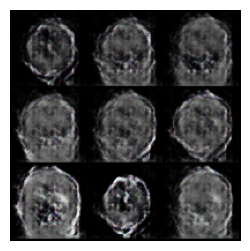

Epoch: 2/100 | Discriminator Loss: 0.2026 | Generator Loss: 4.0762 | D(x): 0.8797 | D(G(z)): 0.0158 / 0.0284
Epoch: 3/100 | Discriminator Loss: 0.3775 | Generator Loss: 4.5151 | D(x): 0.8464 | D(G(z)): 0.1008 / 0.0173
Epoch: 4/100 | Discriminator Loss: 0.3193 | Generator Loss: 5.9733 | D(x): 0.9403 | D(G(z)): 0.1801 / 0.0099
Epoch: 5/100 | Discriminator Loss: 0.1662 | Generator Loss: 5.3113 | D(x): 0.9330 | D(G(z)): 0.0778 / 0.0111
Epoch: 6/100 | Discriminator Loss: 0.2679 | Generator Loss: 4.9866 | D(x): 0.9529 | D(G(z)): 0.1664 / 0.0126


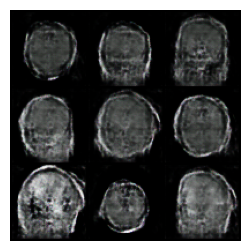

Epoch: 7/100 | Discriminator Loss: 0.2885 | Generator Loss: 4.4503 | D(x): 0.9368 | D(G(z)): 0.1685 / 0.0205
Epoch: 8/100 | Discriminator Loss: 0.4984 | Generator Loss: 5.6487 | D(x): 0.9578 | D(G(z)): 0.2872 / 0.0063
Epoch: 9/100 | Discriminator Loss: 0.2726 | Generator Loss: 4.1191 | D(x): 0.8106 | D(G(z)): 0.0297 / 0.0354
Epoch: 10/100 | Discriminator Loss: 1.0173 | Generator Loss: 3.2490 | D(x): 0.5362 | D(G(z)): 0.0098 / 0.0886
Epoch: 11/100 | Discriminator Loss: 0.3286 | Generator Loss: 3.2954 | D(x): 0.7870 | D(G(z)): 0.0355 / 0.0736


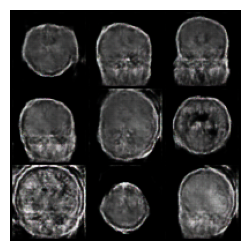

Epoch: 12/100 | Discriminator Loss: 0.6434 | Generator Loss: 7.5317 | D(x): 0.9790 | D(G(z)): 0.4239 / 0.0015
Epoch: 13/100 | Discriminator Loss: 1.1879 | Generator Loss: 2.7567 | D(x): 0.4477 | D(G(z)): 0.0079 / 0.1881
Epoch: 14/100 | Discriminator Loss: 0.7264 | Generator Loss: 1.7713 | D(x): 0.5988 | D(G(z)): 0.0401 / 0.2340
Epoch: 15/100 | Discriminator Loss: 0.4719 | Generator Loss: 5.6887 | D(x): 0.9445 | D(G(z)): 0.3100 / 0.0055
Epoch: 16/100 | Discriminator Loss: 0.3434 | Generator Loss: 5.3566 | D(x): 0.9551 | D(G(z)): 0.2231 / 0.0086


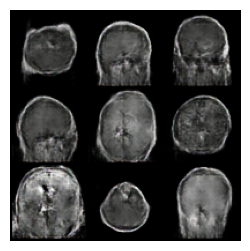

Epoch: 17/100 | Discriminator Loss: 0.2728 | Generator Loss: 3.9738 | D(x): 0.8165 | D(G(z)): 0.0431 / 0.0318
Epoch: 18/100 | Discriminator Loss: 0.5403 | Generator Loss: 1.7369 | D(x): 0.6802 | D(G(z)): 0.0501 / 0.2865
Epoch: 19/100 | Discriminator Loss: 0.3087 | Generator Loss: 3.8214 | D(x): 0.9360 | D(G(z)): 0.1929 / 0.0315
Epoch: 20/100 | Discriminator Loss: 0.2272 | Generator Loss: 3.3150 | D(x): 0.8994 | D(G(z)): 0.0891 / 0.0623
Epoch: 21/100 | Discriminator Loss: 0.8711 | Generator Loss: 6.6105 | D(x): 0.9233 | D(G(z)): 0.4457 / 0.0057


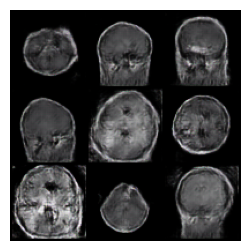

KeyboardInterrupt: 

In [75]:
data_len = len(train_dataloader) # number of batches

img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_G_z1_list = []
D_G_z2_list = []

# for each epoch
for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader, 0):
        '''Update D network: maximize log(D(x)) + log(1 - D(G(z)))'''
        # train with all real images batch
        netD.zero_grad()
        # format batch
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), r_label, dtype=torch.float, device=device)
        # forward pass through D
        output = netD(real_cpu).view(-1)
        # calculate loss 
        errD_real = criterion(output, label)
        # calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        # train with all fake images batch
        # generate batch of latent vectors
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        # generate fake image batch with G
        fake = netG(noise)
        label.fill_(f_label)
        # classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # calculate the gradients for this batch, summed with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # update D
        optimizerD.step()
        
        '''Update G network: maximize log(D(G(z)))'''
        netG.zero_grad()
        label.fill_(r_label) # fake labels are real for generator cost
        # since we updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # calculate G's loss based on this output
        errG = criterion(output, label)
        # calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # update G
        optimizerG.step()
        
        ''' Metrics and evaluation'''
        # save losses for plots    
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_x_list.append(D_x)
        D_G_z1_list.append(D_G_z1)
        D_G_z2_list.append(D_G_z2)
        
    print(f'Epoch: {epoch+1}/{num_epochs} | Discriminator Loss: {errD.item():.4f} | Generator Loss: {errG:.4f} | D(x): {D_x:.4f} | D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    
       
    
    # generate fake image samples to see how generator is learning
    
    if show_images == True and epoch % 5 == 0:
        with torch.no_grad():
            # uncomment the line below to generate a new variety of images every time
            #fixed_noise = torch.randn(64, nz, 1, 1, device=device)
            
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake[:9], padding=2, normalize=True, nrow=3))
            
            plt.figure(figsize=(3, 3))
            plt.axis('off')
            plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
            
            if save_images == True:
                plt.savefig(f'eachEpochImages/epoch_{epoch}_gen_images.png')
                
            # Display image  
            plt.show()
    
     # Save models each 5 epochs
    if epoch % 5 == 0:
        if save_model:
            save_dcgan(netG, netD, path_checkpoint=f"models/chest_epoch_{epoch}_checkpoint.pkl")
        
# Save the final models
save_dcgan(netG, netD, path_checkpoint="models/tumor_final_epoch_checkpoint.pkl")